Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Denoising Diffusion Probabilistic Model on 3D data

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create synthetic 3D images.

[1] - [Ho et al. "Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)


## Setup environment

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import tempfile
import time
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from tqdm import tqdm

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    EnsureChannelFirstd,
    CenterSpatialCropd,
    Compose,
    Lambdad,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    ScaleIntensityRangePercentilesd,
)
from monai.utils import first, set_determinism
from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler, DDIMScheduler

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.12.2
pynrrd version: 1.0.0
clearml version: 1.16.0rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [3]:
set_determinism(42)

## Setup Decathlon Dataset and training and validation data loaders

In this tutorial, we will use the 3D T1 weighted brain images from the [2016 and 2017 Brain Tumor Segmentation (BraTS) challenges](https://www.med.upenn.edu/sbia/brats2017/data.html). This dataset can be easily downloaded using the [DecathlonDataset](https://docs.monai.io/en/stable/apps.html#monai.apps.DecathlonDataset) from MONAI (`task="Task01_BrainTumour"`). To load the training and validation images, we are using the `data_transform` transformations that are responsible for the following:

1. `LoadImaged`:  Loads the brain images from files.
2. `Lambdad`: Choose channel 1 of the image, which is the T1-weighted image.
3. `EnsureChannelFirstd`: Add the channel dimension of the input data.
4. `ScaleIntensityd`: Apply a min-max scaling in the intensity values of each image to be in the `[0, 1]` range.
5. `CenterSpatialCropd`: Crop the background of the images using a roi of size `[160, 200, 155]`.
6. `Resized`: Resize the images to a volume with size `[32, 40, 32]`.

For the data loader, we are using mini-batches of 8 images, which consumes about 21GB of GPU memory during training. Please, reduce this value to run on smaller GPUs.

In [4]:
data_transform = Compose(
    [
        LoadImaged(keys=["image"]),
        Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
        EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        CenterSpatialCropd(keys=["image"], roi_size=[160, 200, 155]),
        Resized(keys=["image"], spatial_size=(32, 40, 32)),
        ScaleIntensityd(keys=["image"]),
        ScaleIntensityRangePercentilesd(keys=["image"], lower=3, upper=97, b_min=0, b_max=1),
    ]
)

In [ ]:
batch_size = 16
num_workers = 8

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=data_transform,
    section="training",
    download=True,
    num_workers=num_workers,
)

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True
)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=data_transform,
    section="validation",
    download=True,
    num_workers=num_workers,
)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

Loading dataset: 100%|██████████| 96/96 [00:25<00:00,  3.72it/s]


### Visualization of the training images

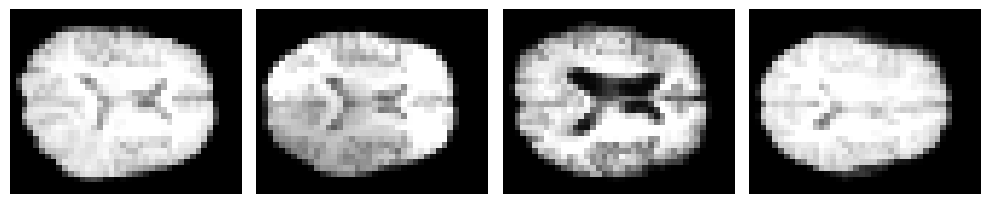

In [6]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(train_ds[i * 20]["image"][0, :, :, 15].detach().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

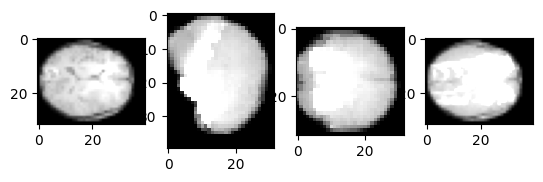

In [7]:
img = first(item["image"] for item in train_ds if "400" in item["image"].meta["filename_or_obj"])
imgn = img[0].detach().cpu().numpy()
f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
ax0.imshow(imgn[..., 15], vmin=0, vmax=1, cmap="gray")
ax1.imshow(np.max(imgn, axis=0), vmin=0, vmax=1, cmap="gray")
ax2.imshow(np.max(imgn, axis=1), vmin=0, vmax=1, cmap="gray")
ax3.imshow(np.max(imgn, axis=2), vmin=0, vmax=1, cmap="gray")

### Define network, scheduler, optimizer, and inferer

We will use a DDPM in this example; for that, we need to define a `DiffusionModelUNet` network that will have as input the noisy images and the values for the timestep `t`, and it will predict the noise that is present in the image.

In this example, we have a network with three levels (with 256, 256, and 512 channels in each). In every level, we will have two residual blocks, and only the last one will have an attention block with a single attention head (with 512 channels).

In [8]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[64, 64, 128],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, 128],
    num_res_blocks=2,
).to(device)

Together with our U-net, we need to define the Noise Scheduler for the diffusion model. This scheduler is responsible for defining the amount of noise that should be added in each timestep `t` of the diffusion model's Markov chain. Besides that, it has the operations to perform the reverse process, which will remove the noise of the images (a.k.a. denoising process). In this case, we are using a `DDPMScheduler`. Here we are using 1000 timesteps and a `scaled_linear` profile for the beta values (proposed in [Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/abs/2112.10752)). This profile had better results than the `linear, proposed in the original DDPM's paper. In `beta_start` and `beta_end`, we define the limits for the beta values. These are important to determine how accentuated is the addition of noise in the image.

In [ ]:
num_train_timesteps = 1000
scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    schedule="scaled_linear_beta",
    beta_start=0.0005,
    beta_end=0.0195,
    clip_sample=False,
)

Text(0, 0.5, 'alpha cumprod')

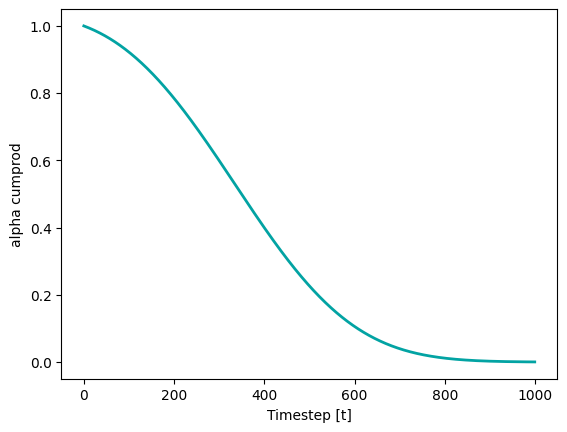

In [10]:
plt.plot(scheduler.alphas_cumprod.cpu(), color=(2 / 255, 163 / 255, 163 / 255), linewidth=2)
plt.xlabel("Timestep [t]")
plt.ylabel("alpha cumprod")

Finally, we define the Inferer, which contains functions that will help during the training and sampling of the model, and the optimizer.

In [11]:
inferer = DiffusionInferer(scheduler)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

## Model training

In this part, we will train the diffusion model to predict the noise added to the images. For this, we are using an MSE loss between the prediction and the original noise. During the training, we are also sampling brain images to evaluate the evolution of the model. In this training, we use Automatic Mixed Precision to save memory and speed up the training.

100%|██████████| 1000/1000 [00:35<00:00, 28.29it/s]
...


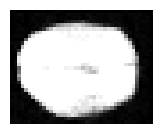

train completed, total time: 1691.9202527999878.


In [ ]:
max_epochs = 40
val_interval = max(1, max_epochs // 5)
use_amp = False
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch:02}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=use_amp):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": f"{epoch_loss / (step + 1):.4f}"})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()

        torch.save(model.state_dict(), f"model_{epoch:04}.pth")

        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            noise = torch.randn_like(images).to(device)
            with torch.no_grad(), autocast(device_type="cuda", enabled=use_amp):
                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=images.device).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        image = torch.randn((1, 1, 32, 40, 32))
        image = image.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(device_type="cuda", enabled=use_amp):
            image = inferer.sample(input_noise=image, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0, :, :, 15].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

### Learning curves

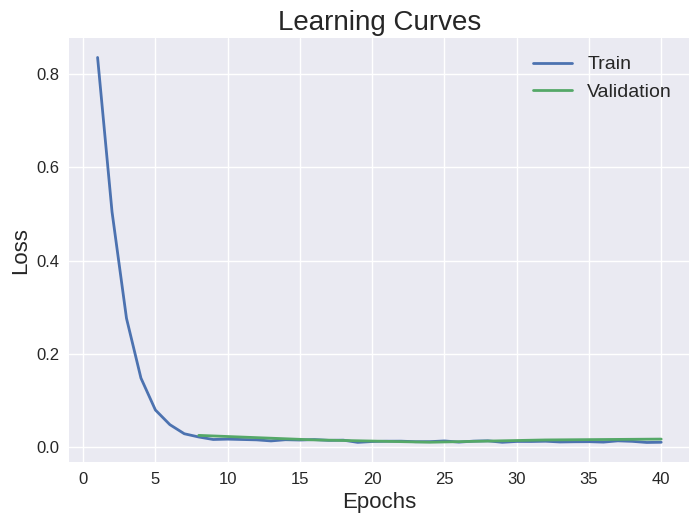

In [13]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Sampling Brain Image

In order to sample the brain images, we need to pass the model an image containing just noise and use it to remove the noise of the image iteratively. For that, we will use the `.sample()` function of the `inferer`.

In [ ]:
model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [00:31<00:00, 31.56it/s]


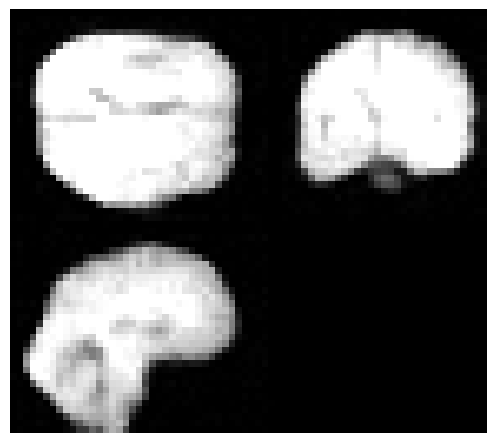

In [15]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Sampling with Denoising Diffusion Implicit Model Scheduler

Recent papers have proposed different ways to improve the sampling speed by using fewer steps in the denoising process. In this example, we are using a `DDIMScheduler` (from [Song et al. "Denoising Diffusion Implicit Models"](https://arxiv.org/abs/2010.02502)) to reduce the original number of steps from 1000 to 250.

In [16]:
scheduler_ddim = DDIMScheduler(
    num_train_timesteps=num_train_timesteps,
    schedule="scaled_linear_beta",
    beta_start=0.0005,
    beta_end=0.0195,
    clip_sample=False,
)

scheduler_ddim.set_timesteps(num_inference_steps=250)

model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)

image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler_ddim)

100%|██████████| 250/250 [00:08<00:00, 29.97it/s]


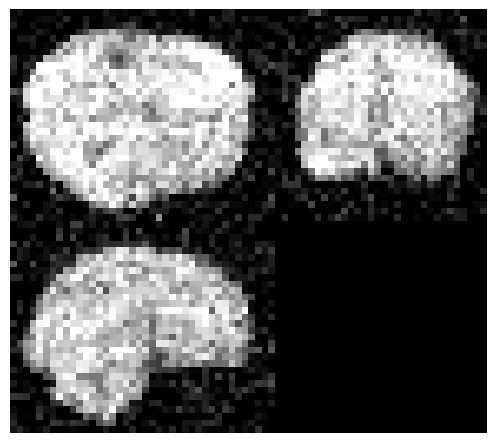

In [17]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)